# Diseño Experimental III

Las metodologías de diseño experimental ayudan a:
- Eliminar la mayor cantidad de **variación natural** posible
- Prevenir que la variabilidad no removida confundiera o **sesgara** los resultados
- Detectar causa y efectos con la **mínima cantidad de esfuerzo experimental**



Para abrir en GoogleColab:  <a target="_blank" href="https://githubtocolab.com/SysBioengLab/IIQ3402-Statistical-Design/blob/main/Clases/Clase17_DisenoExperimentalIII.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Diseño Completamente Aleatorio (CRD)

El análisis de CRD permite concluir causalidad si se realizó bien el diseño contabilizando la replicación y aleatoriedad.



## Caso de Estudio: Crecimiento de la masa de pan

In [ ]:
# Requerimientos
!pip install seaborn -q # Para visualización y datasets
!pip install scipy -q # Para analísis estadísticos
!pip install numpy -q # Para cálculos científicos
!pip install pandas -q # Para almacenamiento y trabajo con datos
!pip install matplotlib -q # Para visualización
!pip install statsmodels -q # Para analísis estadísticos
!pip install rdatasets -q # datasets de R
!pip install scikit-learn -q # Análisis relacionados a Machine Learning
!pip install pingouin -q # Análisis estadísticos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from google.colab import files # permite hacer cosas con google colab
####
# OJO: Este método solo sirve en google colab.
# Para hacerlo en vscode o otro con .to_excel debería bastar
####

# armamos el experimentl
df_exp = pd.DataFrame({
    'Loaf': range(1, 13),
    'time': pd.Categorical(np.repeat([35, 40, 45], repeats=4)),
    'height': np.nan
})

# Aleatorizamos el experimento
df_exp = df_exp.sample(n=12, random_state=42).reset_index(drop=True)

### Exportamos el df para llenarlo manualmente
df_exp.to_excel('exp_bread.xlsx', index = False) # guardamos el excel
files.download('exp_bread.xlsx') # descargamos

Ahora podemos importamos el Excel para llenarlos manualmente:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tiempo

# subimos el excel a Google Colab
path = list(files.upload().keys())[0]
df_bread = pd.read_excel(path)

Saving exp_bread.xlsx to exp_bread (10).xlsx


In [ ]:
display(df_bread)

,Loaf,time,height
0,11,45,6.50
1,10,45,8.75
2,1,35,4.50
3,9,45,9.75
4,6,40,6.50
5,3,35,5.50
6,2,35,5.00
7,12,45,8.25
8,5,40,6.50
9,8,40,9.50


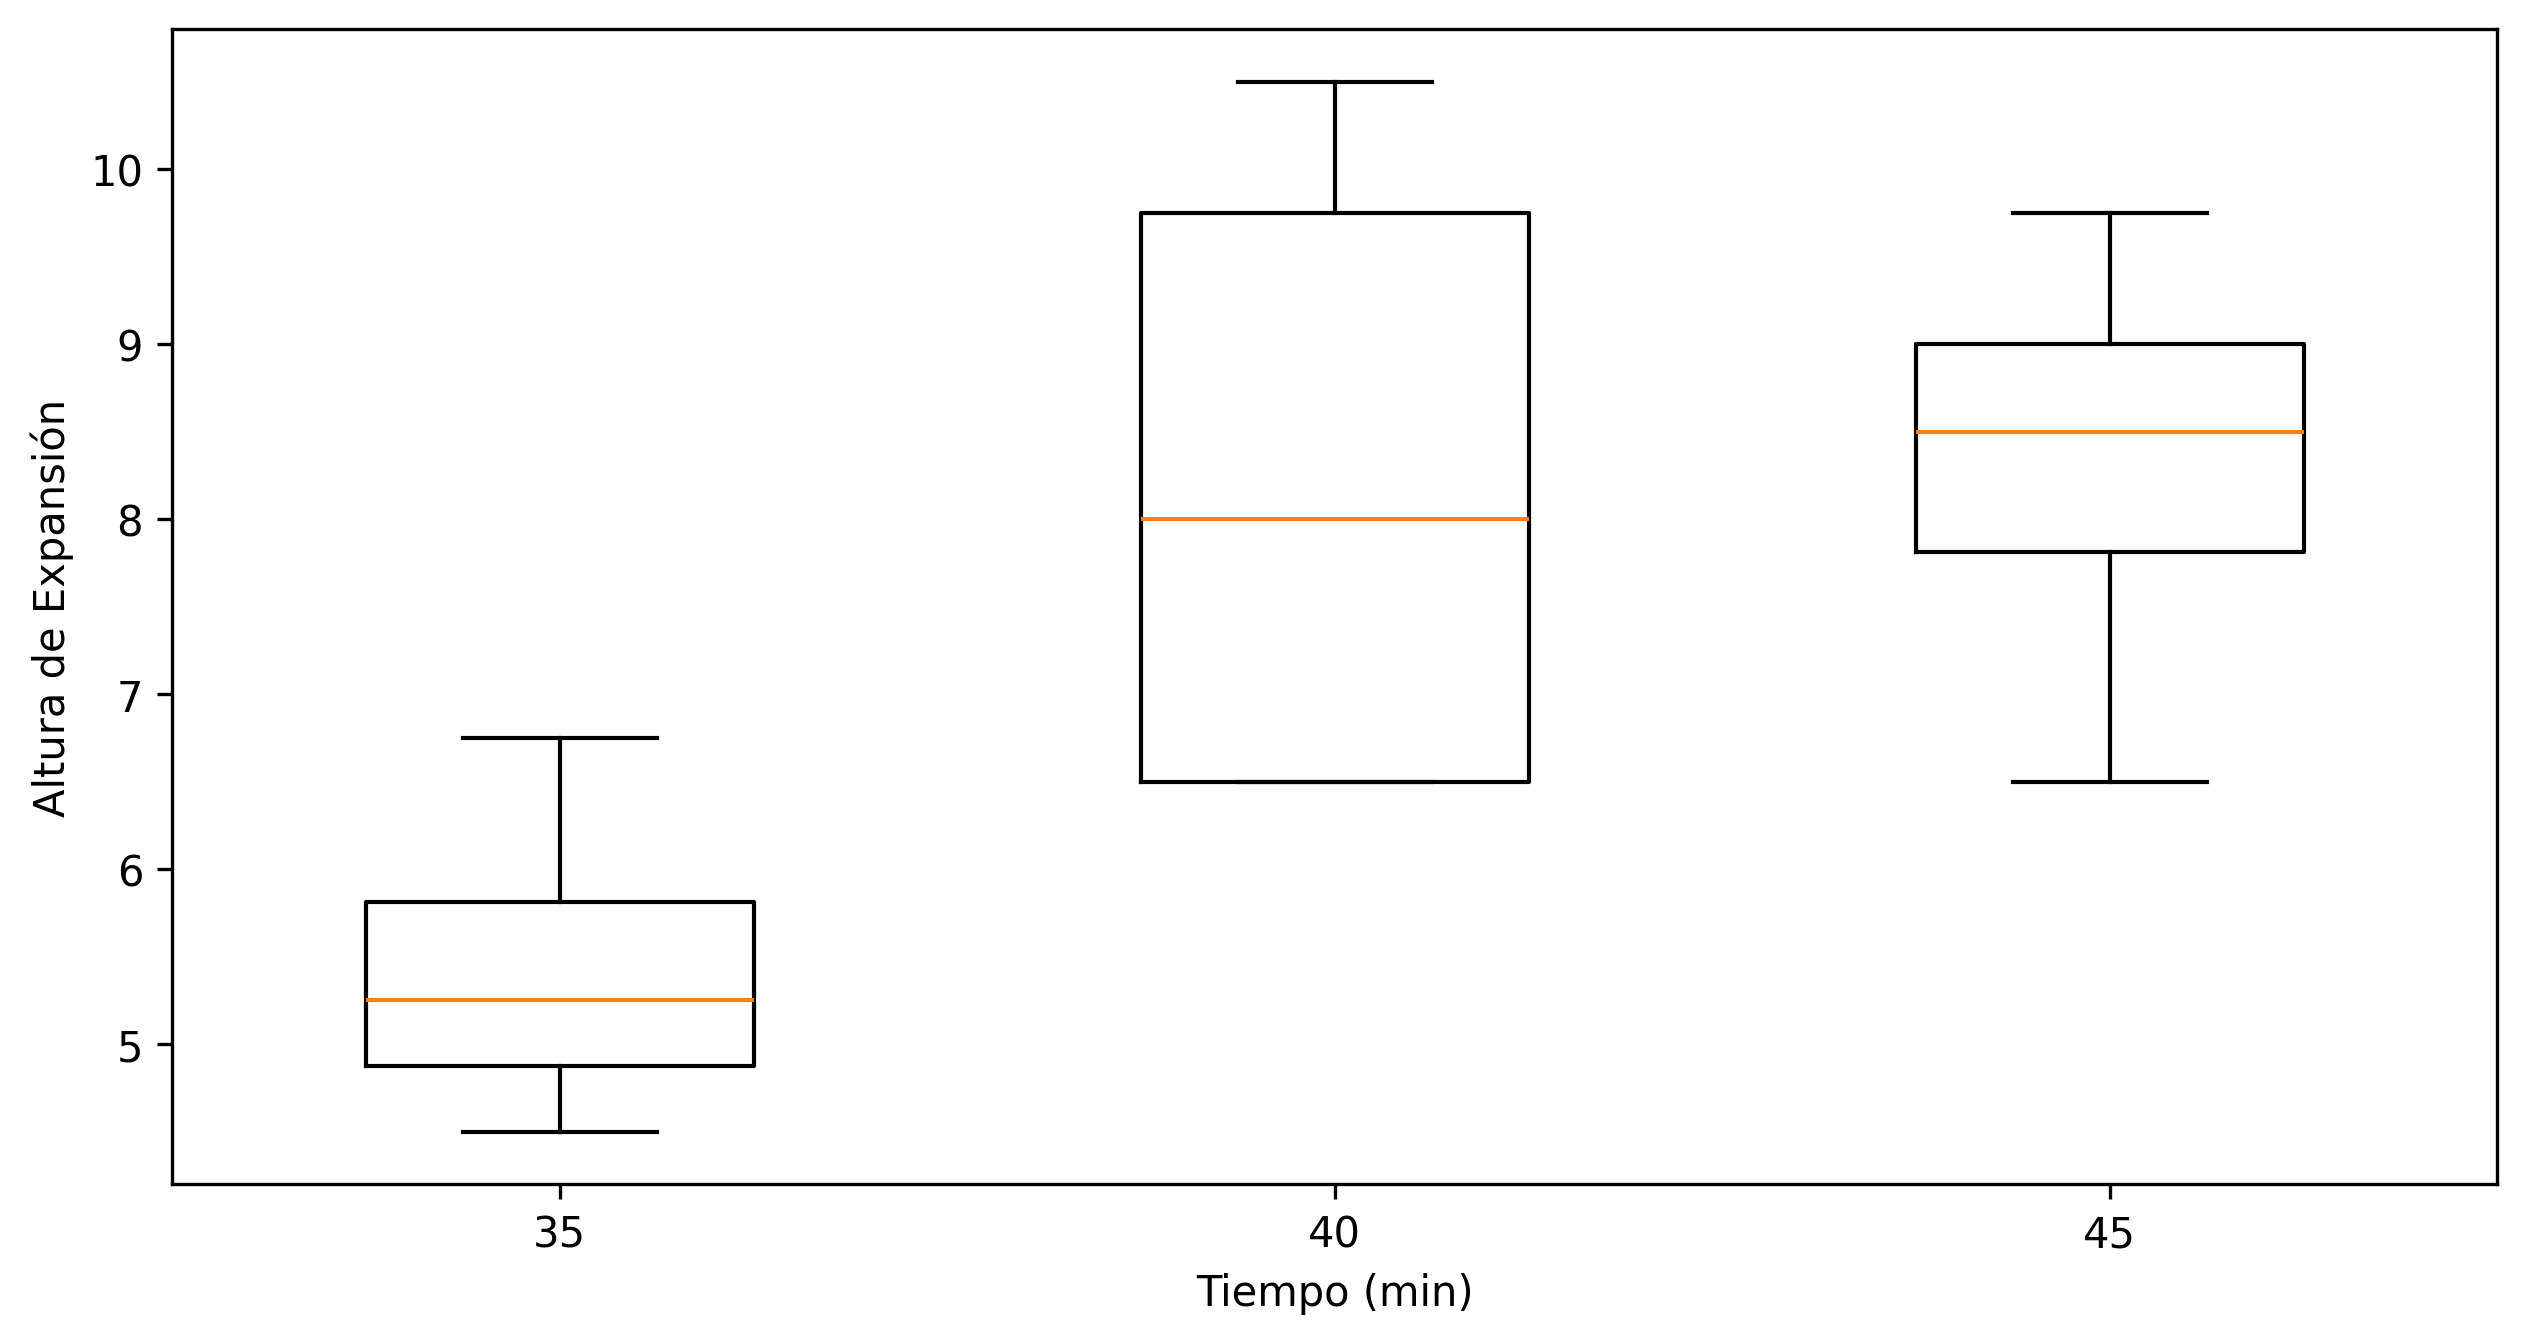

In [ ]:

fig, ax = plt.subplots(figsize = (10,5), dpi = 300)
for posi, time in enumerate(sorted(df_bread['time'].unique())):
    ax.boxplot(
        df_bread[df_bread['time'] == time]['height'],
        positions = [posi],
        tick_labels = [time],
        widths = 0.5,
        showfliers = False
    )
ax.set_ylabel('Altura de Expansión')
ax.set_xlabel('Tiempo (min)')
plt.show()

Con los datos obtenidos es posible generar un análisis ANOVA de forma de poder encontrar causalidad dentro del experimento.

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ojo con ponder C(time) para tratar el tiempo como variable categórica
model_bread = ols('height ~ C(time)',
                  data = df_bread).fit()
anova_table = sm.stats.anova_lm(model_bread)
display(anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
C(time),2.0,21.572917,10.786458,4.602222,0.042004
Residual,9.0,21.093750,2.343750,NaN,NaN


Análizamos los residual para revisar la normalidad y homocedasticidad de estos.

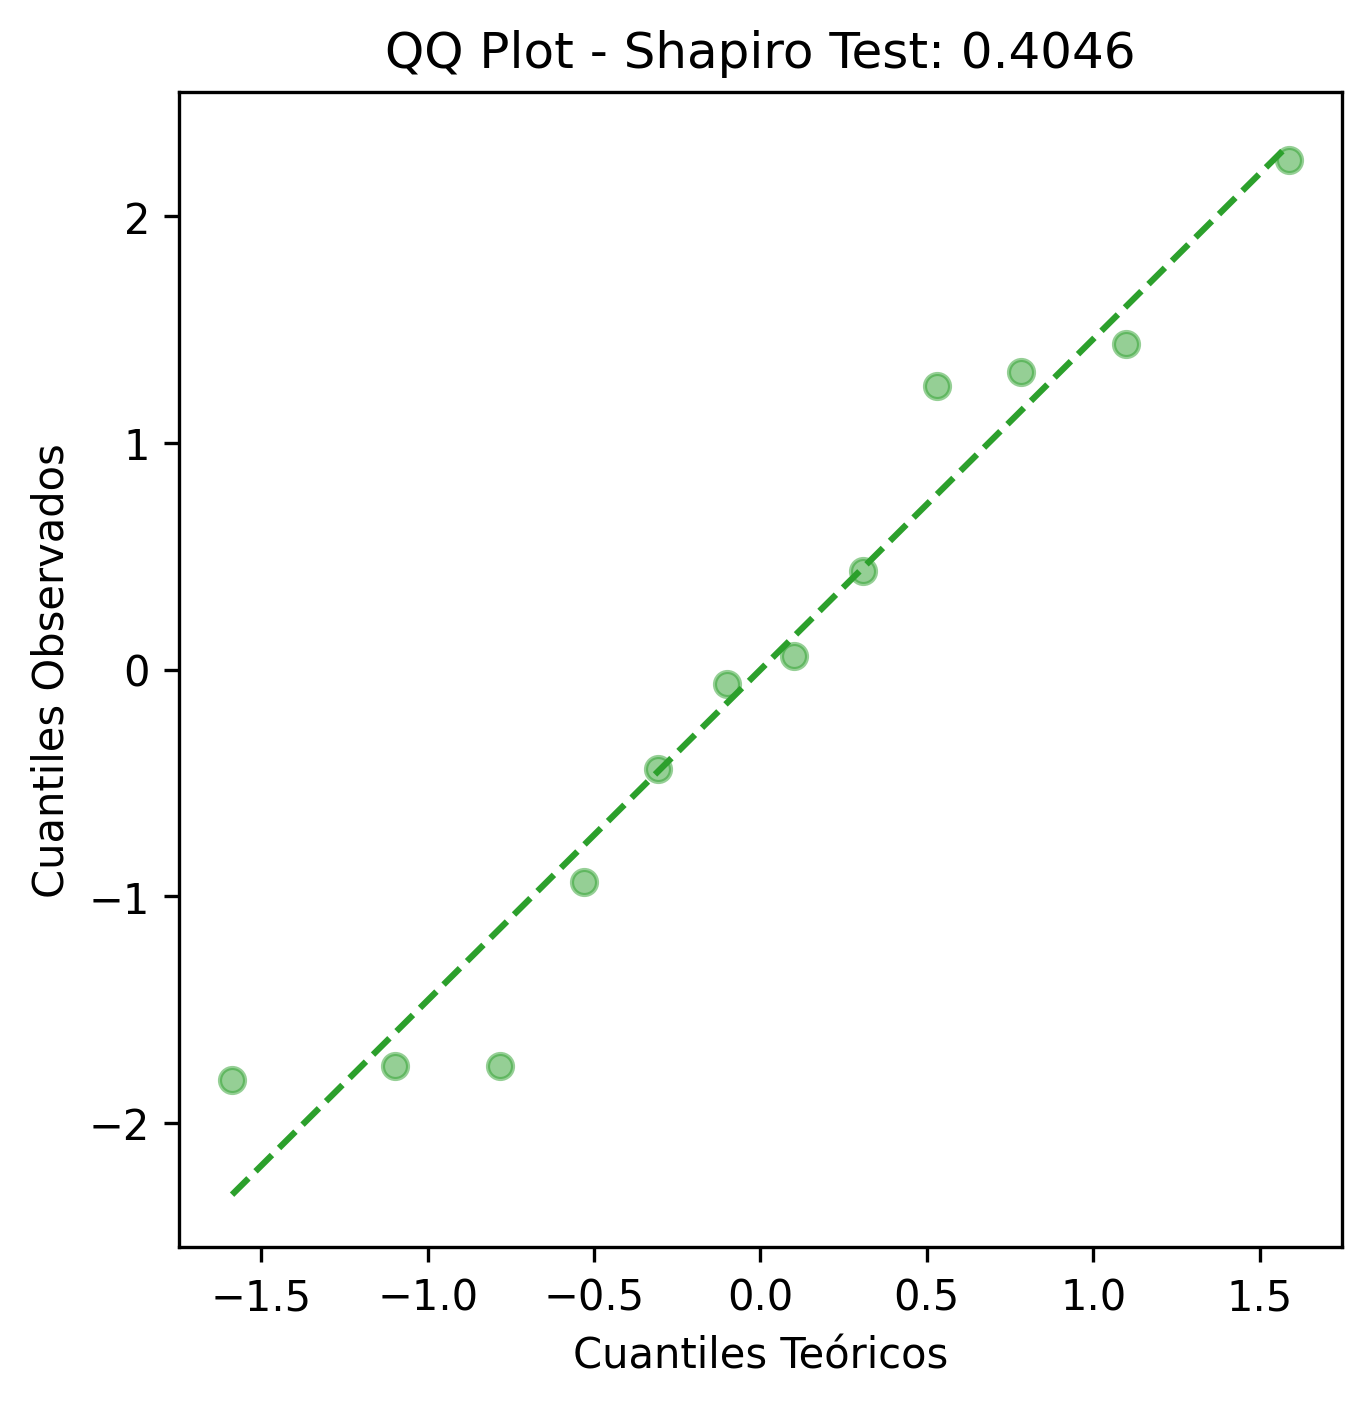

Shapiro Test:  0.4045836710121668


In [ ]:
import scipy.stats as st
residuals_bread = model_bread.resid
fig, ax = plt.subplots(figsize = (5,5), dpi = 300)
(osm, osr), (slope, intercept, r) = st.probplot(residuals_bread, fit = True)
ax.scatter(osm, osr, edgecolors = 'tab:green', facecolor = 'tab:green', alpha = 0.50)
ax.plot(osm, osm*slope + intercept, color = 'tab:green', linestyle = '--')
ax.set_xlabel('Cuantiles Teóricos')
ax.set_ylabel('Cuantiles Observados')
ax.set_title(f'QQ Plot - Shapiro Test: {st.shapiro(residuals_bread).pvalue:.4f}')
plt.show()
print('Shapiro Test: ',
st.shapiro(residuals_bread).pvalue)

Otra pruebam útil es la preuba de Breusch-Pagan, la cual esta diseñada para detectar heterocedasticidad en un análisis de regresión.

In [ ]:
import statsmodels.stats.api as sms
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model_bread.resid,
                            model_bread.model.exog, robust=True)
dict_bptest = dict(zip(name, test))
print('Breusch-Pagan Test')
print(pd.DataFrame(dict_bptest, index = [0]).T)


Breusch-Pagan Test
                                      0
Lagrange multiplier statistic  5.537568
p-value                        0.062738
f-value                        3.855987
f p-value                      0.061726


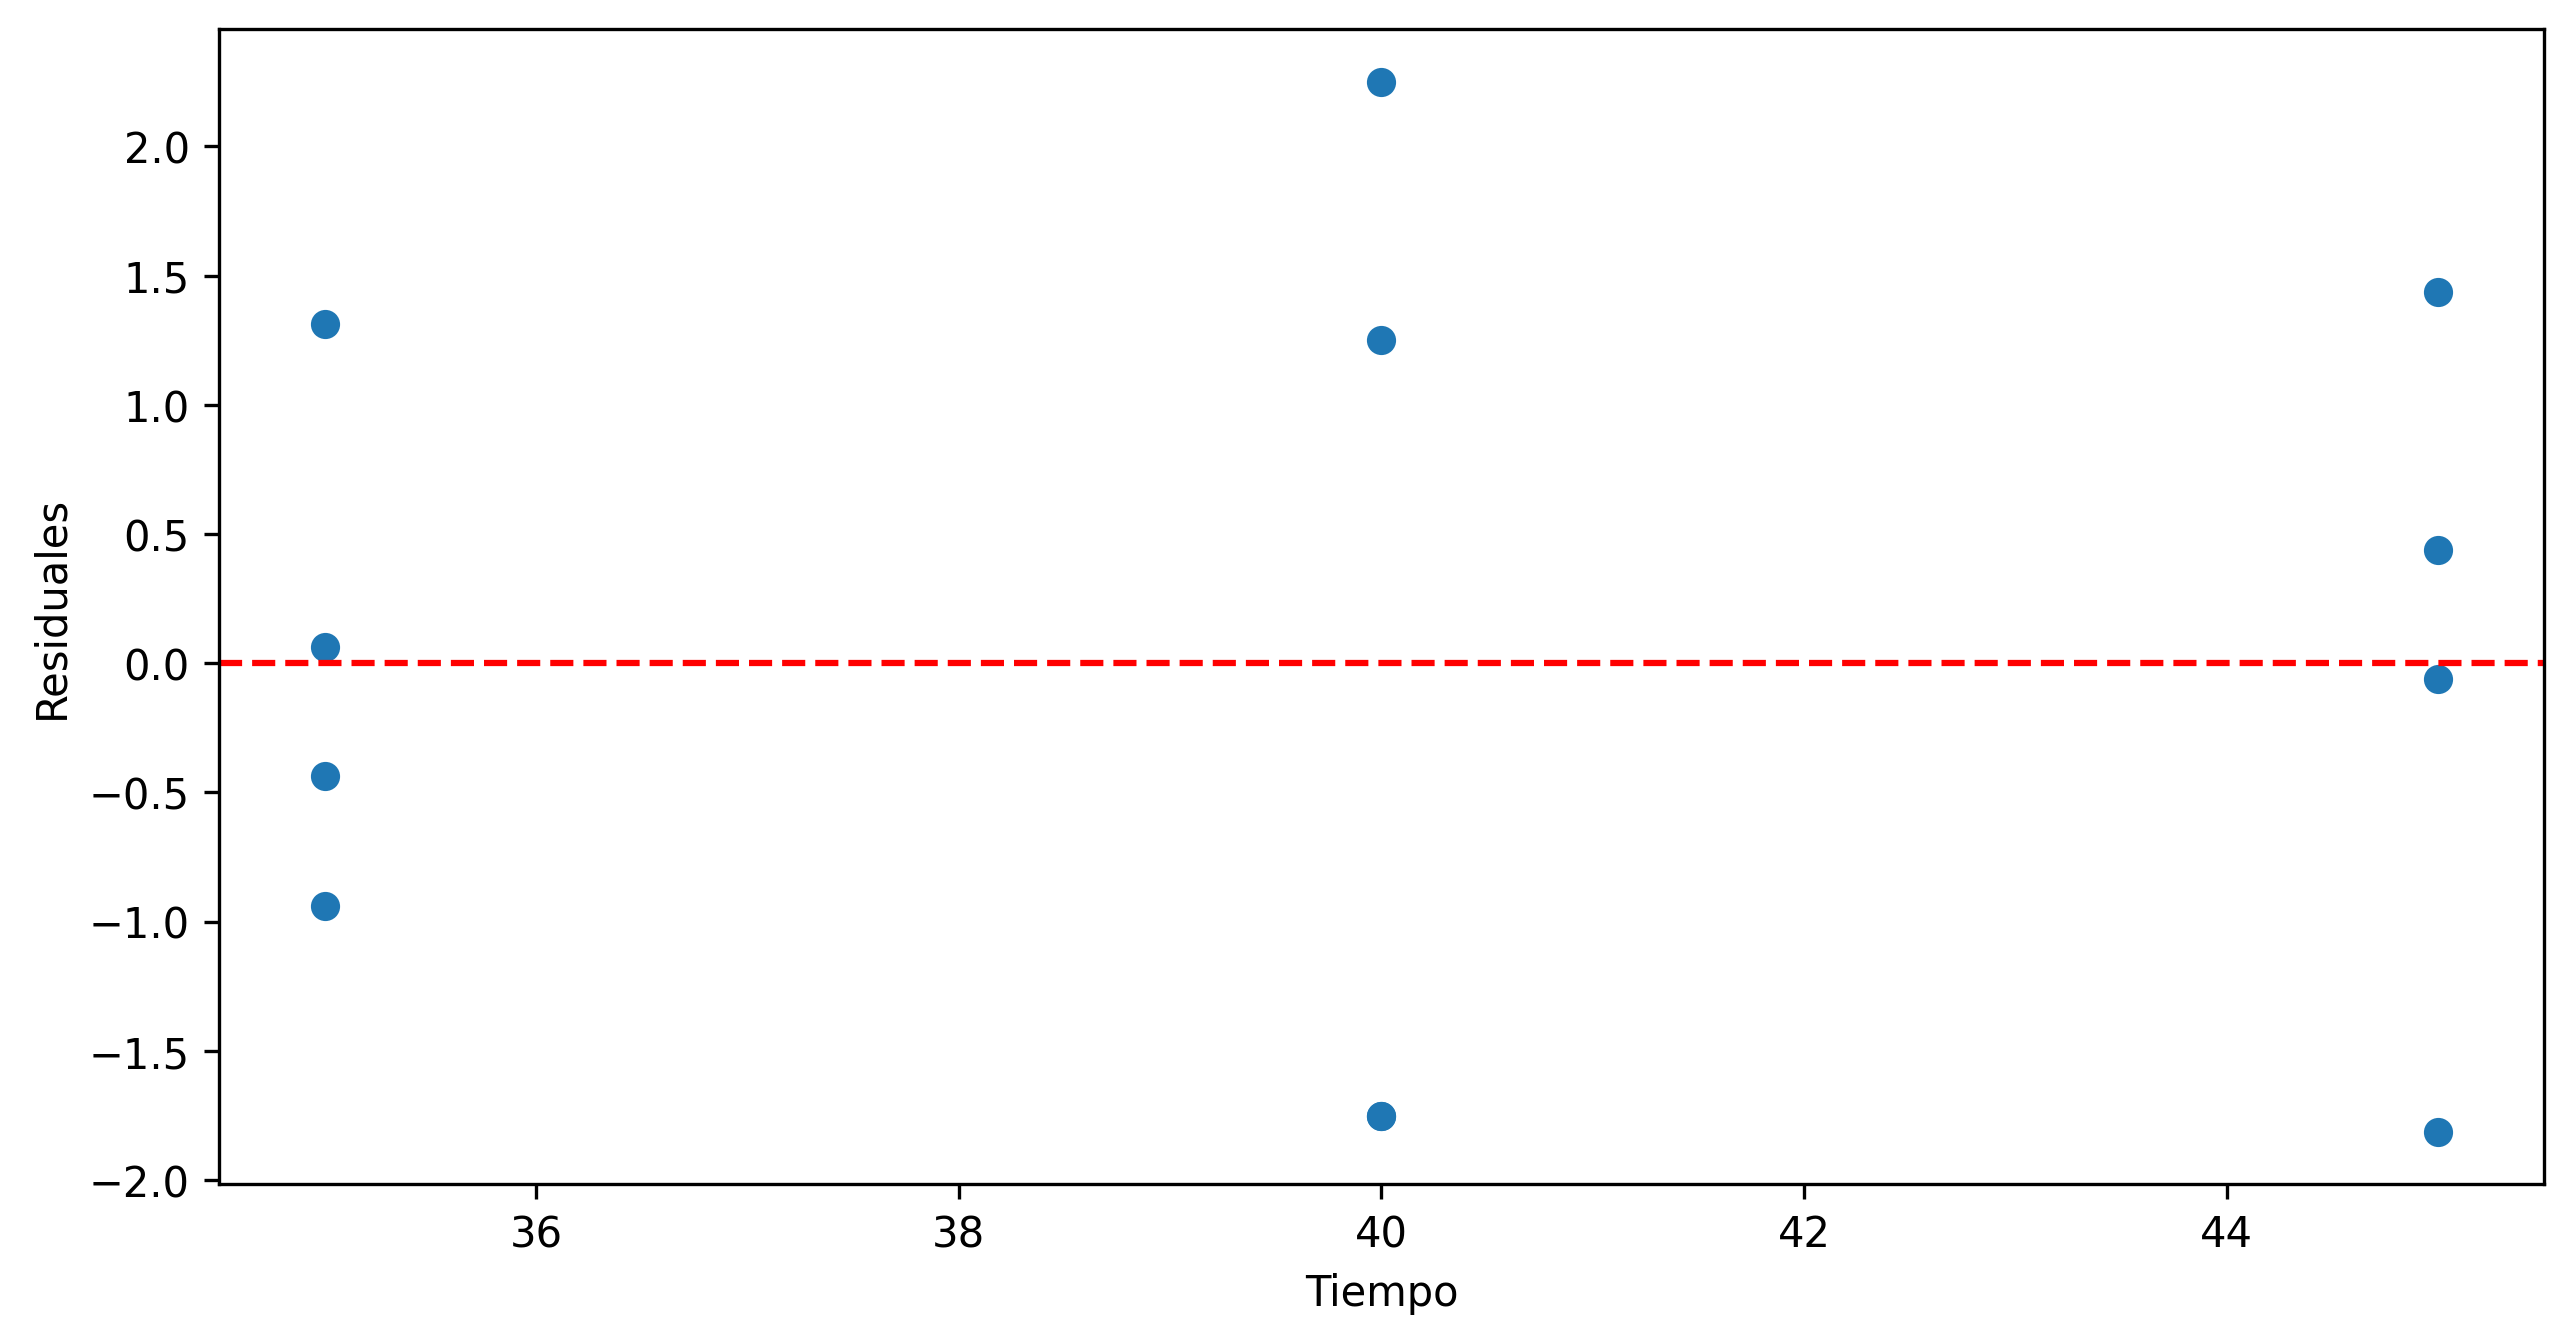

In [ ]:

# plot
fig, ax = plt.subplots(figsize = (10,5), dpi = 300)
ax.scatter( df_bread['time'], model_bread.resid,)
ax.axhline(y = 0, color = 'r', linestyle = '--')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Residuales')
plt.show()

En este caso, el p-value de la prueba es muy cercano al límite, por lo cual el resultado no es concluso.

Al no cumplirse los supuestos, es necesario revisar la linealidad del nivel de Factores con la variable respuesta, si existe curvatura, es posible que requiera una transformación.

### Análisis Transformación BoxCox

Esta transformación permite estabilizar la varianza y mejorar la sensibilidad de los análisis por medio de la siguiente formula denominadas *Power Transformations*:
$$ Y = y^\lambda$$
Donde $\lambda$ es un factor que se estima mediante la relación entre la desviación estándar ($\sigma$) y la media ($\mu$).

En particular, la implementación de BoxCox se denomina por la siguiente transformación:
$$
Y = \begin{cases}
\frac{y^\lambda - 1}{\lambda}\; \text{if } \lambda\neq0\\
\log(y) \; \text{if } \lambda=0
\end{cases}
$$

En este caso, $\lambda$ es calculado mediante la maximización del *log-likelihood* de la función (para mayor información visitar esta [documentación](https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.stats.boxcox_llf.html#scipy.stats.boxcox_llf)). Y los valores de y son estrictamente positivos.


In [ ]:
# Transformación BoxCox
loaf_boxcox, lambda_box = st.boxcox(df_bread['height'])
print(f'Lambda Óptimo: {lambda_box:.4f}')
df_bread['loaf_boxcox'] = loaf_boxcox

Lambda Óptimo: 0.2558


In [ ]:
## Con esto evaluamos el modelo ANOVA
model_boxcox_bread = ols('loaf_boxcox ~ C(time)', data = df_bread).fit()
anova_table_boxcox = sm.stats.anova_lm(model_boxcox_bread)
print(anova_table_boxcox)

           df    sum_sq   mean_sq         F   PR(>F)
C(time)   2.0  1.220934  0.610467  5.374209  0.02912
Residual  9.0  1.022328  0.113592       NaN      NaN


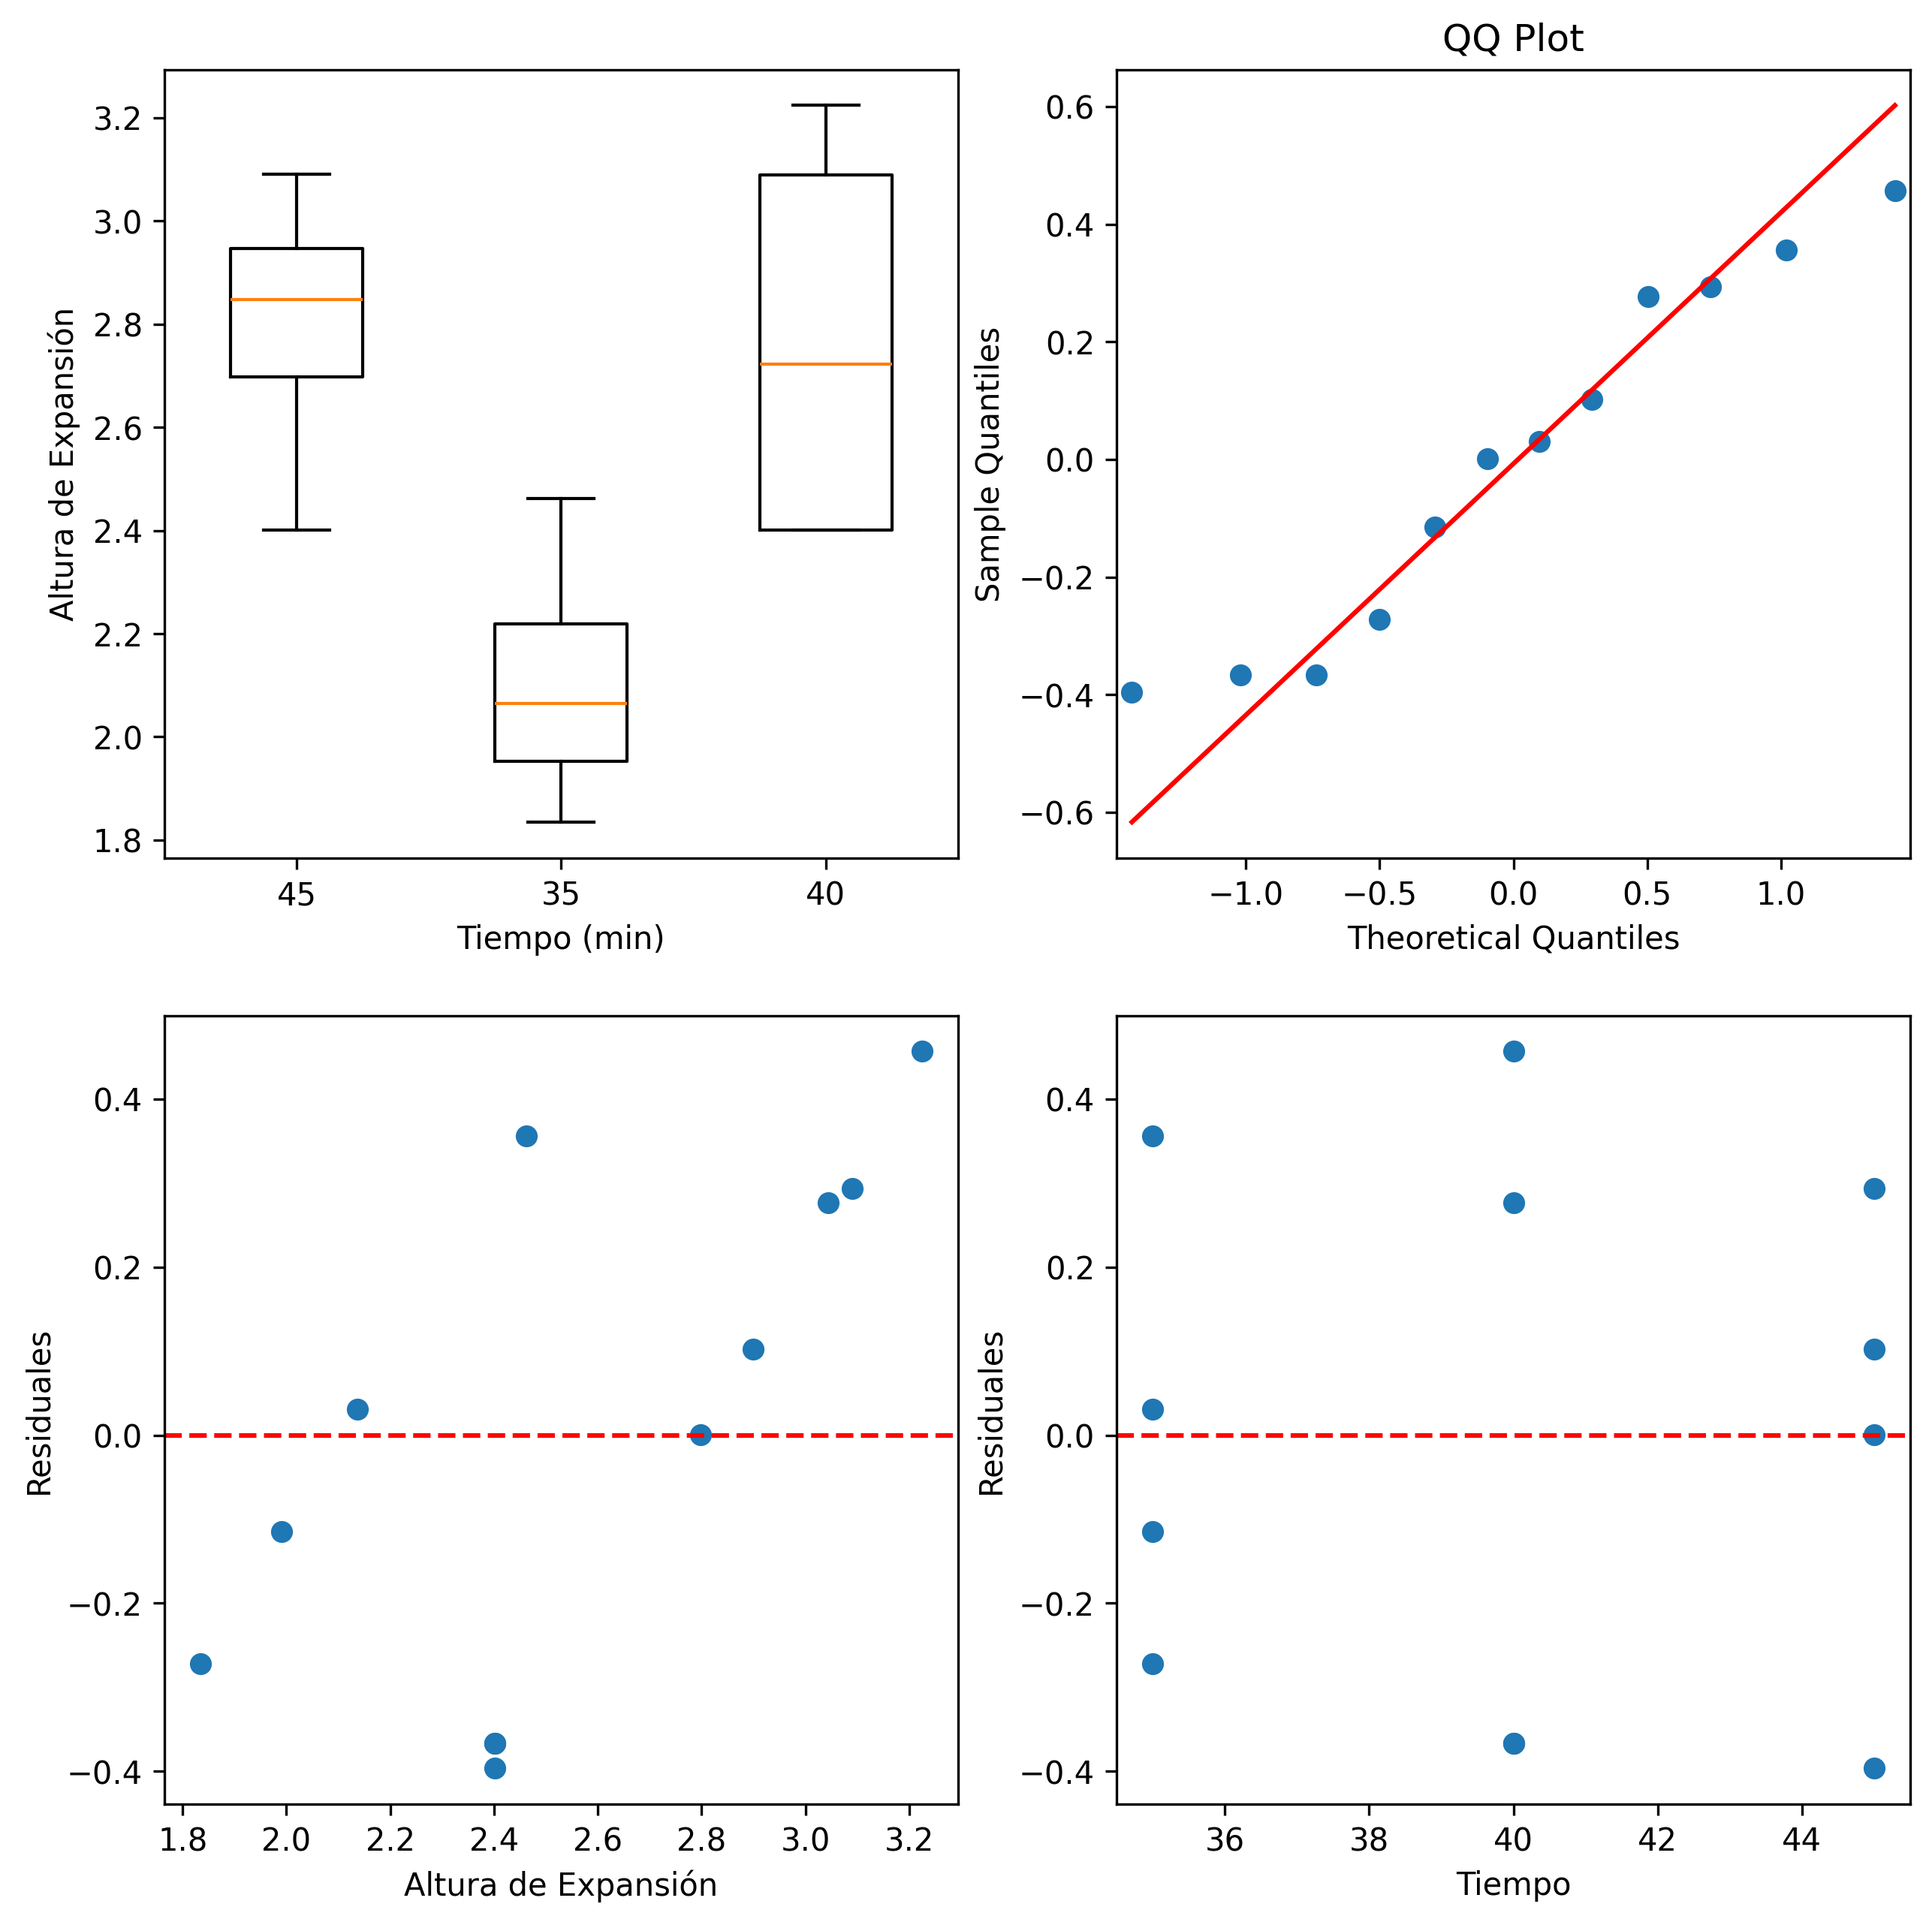

Sahpiro-Wilk Test: 0.2925
Breusch-Pagan Test: 0.1382


In [ ]:
# Análisis exploratorio y de propiedades de los datos después de transformación
fig, ax = plt.subplots(2,2, figsize = (10,10), dpi = 300)
for posi, time in enumerate(df_bread['time'].unique()):
    ax[0,0].boxplot(
        df_bread[df_bread['time'] == time]['loaf_boxcox'],
        positions = [posi],
        tick_labels = [time],
        widths = 0.5,
        showfliers = False
    )

ax[0,0].set_ylabel('Altura de Expansión')
ax[0,0].set_xlabel('Tiempo (min)')

sm.qqplot(model_boxcox_bread.resid, line = 'q', ax = ax[0,1])
ax[0,1].set_title('QQ Plot')

ax[1,0].scatter( df_bread['loaf_boxcox'], model_boxcox_bread.resid,)
ax[1,0].axhline(y = 0, color = 'r', linestyle = '--')
ax[1,0].set_xlabel('Altura de Expansión')
ax[1,0].set_ylabel('Residuales')
ax[1,1].scatter( df_bread['time'], model_boxcox_bread.resid,)
ax[1,1].axhline(y = 0, color = 'r', linestyle = '--')
ax[1,1].set_xlabel('Tiempo')
ax[1,1].set_ylabel('Residuales')

plt.show()

bp_test = sms.het_breuschpagan(model_boxcox_bread.resid, model_boxcox_bread.model.exog)
print(f'Sahpiro-Wilk Test: {st.shapiro(model_boxcox_bread.resid).pvalue:.4f}')
print(f'Breusch-Pagan Test: {bp_test[1]:.4f}')

Ahora, podemos asumir homocidasticidad dado los test de Shapiro-Wilk y Breusch-Pagan.

Evaluamos ahora los diferentes niveles de nuestro experimento para buscar diferencias entre los grupos (tiempos diferentes).

In [ ]:
## T-test pareados
# modelo normal
pw_ttest_time = model_bread.t_test_pairwise('C(time)',method = 'bonferroni')
rf_ttest = pw_ttest_time.result_frame

tt_pval = {}
for row in rf_ttest.index:
    row_list = row.split('-')
    row_name = row_list[0]
    col_name = row_list[1]
    if row_name not in tt_pval:
        tt_pval[row_name] = {}

    tt_pval[row_name][col_name] = rf_ttest.loc[row, 'pvalue-bonferroni']
print('Pairwise ttest')
print(pd.DataFrame(tt_pval).T)

# modelo ajustado con boxcox

pw_ttest_time = model_boxcox_bread.t_test_pairwise('C(time)',method = 'bonferroni')
rf_ttest = pw_ttest_time.result_frame

tt_pval = {}
for row in rf_ttest.index:
    row_list = row.split('-')
    row_name = row_list[0]
    col_name = row_list[1]
    if row_name not in tt_pval:
        tt_pval[row_name] = {}

    tt_pval[row_name][col_name] = rf_ttest.loc[row, 'pvalue-bonferroni']
print('\nPairwise ttest transformación con BoxCox')
print(pd.DataFrame(tt_pval).T)


## Pairwise Tukey analisis
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_bread = pairwise_tukeyhsd(endog = df_bread['loaf_heights'], groups = df_bread['time'])
print('\nTukey HSD')
print(tukey_bread)
tukey_bread_boxcox = pairwise_tukeyhsd(endog = df_bread['loaf_boxcox'], groups = df_bread['time'])
print('\nTukey HSD con BoxCox')
print(tukey_bread_boxcox)

Pairwise ttest
          35   40
40  0.086487  NaN
45  0.078676  1.0

Pairwise ttest transformación con BoxCox
          35   40
40  0.064700  NaN
45  0.052858  1.0

Tukey HSD
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    35     40   2.8125 0.0676 -0.2099 5.8349  False
    35     45    2.875 0.0618 -0.1474 5.8974  False
    40     45   0.0625 0.9982 -2.9599 3.0849  False
---------------------------------------------------

Tukey HSD con BoxCox
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    35     40   0.6614 0.0513  -0.004 1.3268  False
    35     45   0.6909 0.0423  0.0255 1.3563   True
    40     45   0.0295 0.9916 -0.6359 0.6949  False
---------------------------------------------------


A partir de los análsis, podemos encontrar que los valores no son significativos en su mayoría, por lo cual es necesario analizar el **poder del diseño experimental**.

### Poder del diseño Experimental

Para poder analizar el poder estadístico del test realizado, es necesario considerar la distribución F de la cual el test anova proviene. Con esta información, podemos generar conclusiones de nuestros experimentos en base a como se comporta el poder en base a replicaciones.



In [ ]:
def F_power1(alpha, nlev, nreps, delta, sigma):
    """
    Calculates the power of a one-way anova test using a
    non-central F-distribution with nu1 and nu2 degrees of freedom and
    noncentrality parameter nc.
    The function takes the significance level, the number of levels,
    the number of repetitions, the effect size and the standard deviation.
    ---
    Parameters:
    alpha: float
        significance level
    nlev: int
        number of levels
    nreps: int
        number of repetitions
    delta: float
        effect size
    sigma: float
        standard deviation
    ---
    Returns:
    power: float
        power of the test
    ---
    Reference:
    Adaptation from the R function Fpower1
    https://github.com/cran/daewr
    """
    # degrees of freedom
    df1 = nlev - 1
    df2 = nlev*(nreps-1)
    # critical value of F
    fcrit = st.f.ppf(1 - alpha, df1, df2)
    # non-centrality parameter
    # calculated as the effec
    css = (delta**2)/2
    nc = (nreps*css)/(sigma**2)
    power = 1 - st.ncf.cdf(fcrit, df1, df2, nc)
    return power

reps = np.arange(2,10+1) # +1 por como python trabaja con las listas
nlev = 3 # niveles de los factores a analizar
alpha = 0.05 # significancia
delta = 3 # diferencia estadística practica
sigma = np.sqrt(2.1) # disviación estándar

for r in reps:
    power = F_power1(
        alpha = alpha,
        nlev = nlev,
        nreps = r,
        delta = delta,
        sigma = sigma
    )
    print(f'Power para {r} repeticiones: {power:.4f}')


Power para 2 repeticiones: 0.1948
Power para 3 repeticiones: 0.4042
Power para 4 repeticiones: 0.5903
Power para 5 repeticiones: 0.7329
Power para 6 repeticiones: 0.8330
Power para 7 repeticiones: 0.8991
Power para 8 repeticiones: 0.9408
Power para 9 repeticiones: 0.9661
Power para 10 repeticiones: 0.9810


# Diseño Factorial Completamente Aleatorizado (CRFD)

El CRFD considera casos en donde ocurre interacción entre los parámetros a estudiar. Así, el análisis de ANOVA requiere ser modificado para incorporar no solo la variabilidad de los distintos factores, sino también el término de interacción.

Así, para un ANOVA de dos vías (two-way ANOVA) existen 2 términos de factores y un término de interacción. Por tanto, la hipótesis a probar es justamente sobre estos 3 términos.


## Caso de Estudio: Factores de combustión de monóxido de carbono (CO)

In [ ]:
# Factores
import itertools as it
factores = ['EtOH','ratio']
eth_list = [0.1,0.2,0.3]
ratio = [14,15,16]
produc = it.product(eth_list,ratio)
factores_list = list(produc)*2 # Replication
df_co = pd.DataFrame(columns = ['eth', 'ratio', 'co'])
df_co['eth'] = [i[0] for i in factores_list]
df_co['ratio'] = [i[1] for i in factores_list]
# Datos de co
df_co['co'] = [
    66, 72, 68, 78, 80, 66, 90, 75, 60, 62, 67, 66, 81, 81, 69, 94, 78, 58
]

### Poder estadístico
Para calcular el poder estadístico, al igual que antes, se debe probar los diferentes nibeles de replicación, con el fin de poder asegurar un poder suficiente.

In [ ]:
def F_power2(alpha, nlev, nreps, delta, sigma):
    """
    Calculates the power of a two-way anova test using a
    non-central F-distribution with nu1 and nu2 degrees of freedom and
    noncentrality parameter nc.
    The function takes the significance level, the number of levels,
    the number of repetitions, the effect size and the standard deviation.
    ---
    Parameters:
    alpha: float
        significance level
    nlev: list
        number of levels pero experiment
    nreps: int
        number of repetitions
    delta: float
        effect size
    sigma: float
        standard deviation
    ---
    Returns:
    power: float
        power of the test
    ---
    Reference:
    Addaptation from the R function Fpower1
    https://github.com/cran/daewr
    """
    if len(nlev) < 2:
        raise ValueError('nlev must have at least 2 elements')
    a = nlev[0]
    b = nlev[1]
    # centrality calculations
    css = (delta**2)/2
    ncb = a * (nreps * css)/(sigma**2)
    nca = b * (nreps * css)/(sigma**2)
    # degrees of freedom
    dfa = a - 1
    dfb = b - 1
    df2 = a * b * (nreps - 1)
    # critical value of F
    fcrit_a = st.f.ppf(1 - alpha, dfa, df2)
    fcrit_b = st.f.ppf(1 - alpha, dfb, df2)
    # power
    power_a = 1 - st.ncf.cdf(fcrit_a, dfa, df2, nca)
    power_b = 1 - st.ncf.cdf(fcrit_b, dfb, df2, ncb)
    return power_a, power_b

alpha = 0.05
a = 3
b = 3
nreps = np.arange(2,5+1)
delta = 10
# calculamos sigma en base a los conocmientos previos
sigma = df_co[(df_co['eth'] == 0.1) & (df_co['ratio'] == 14)]['co'].std()
print('Variaciones de numero de replicas')
for r in nreps:
    power_a, power_b = F_power2(
        alpha = alpha,
        nlev = [a,b],
        nreps = r,
        delta = delta,
        sigma = sigma)
    print(f'Power para {r} repeticiones y delta {delta}: Power a: {power_a:.4f}, Power b: {power_b:.4f}')
print('\nVariaciones de Delta')
delta_list = np.arange(4,12)
for d in delta_list:
    power_a, power_b = F_power2(
        alpha = alpha,
        nlev = [a,b],
        nreps = 2,
        delta = d,
        sigma = sigma)
    print(f'Power para {2} repeticiones y delta {d}: Power a: {power_a:.4f}, Power b: {power_b:.4f}')

Variaciones de numero de replicas
Power para 2 repeticiones y delta 10: Power a: 0.9971, Power b: 0.9971
Power para 3 repeticiones y delta 10: Power a: 1.0000, Power b: 1.0000
Power para 4 repeticiones y delta 10: Power a: 1.0000, Power b: 1.0000
Power para 5 repeticiones y delta 10: Power a: 1.0000, Power b: 1.0000

Variaciones de Delta
Power para 2 repeticiones y delta 4: Power a: 0.4411, Power b: 0.4411
Power para 2 repeticiones y delta 5: Power a: 0.6310, Power b: 0.6310
Power para 2 repeticiones y delta 6: Power a: 0.7938, Power b: 0.7938
Power para 2 repeticiones y delta 7: Power a: 0.9041, Power b: 0.9041
Power para 2 repeticiones y delta 8: Power a: 0.9633, Power b: 0.9633
Power para 2 repeticiones y delta 9: Power a: 0.9885, Power b: 0.9885
Power para 2 repeticiones y delta 10: Power a: 0.9971, Power b: 0.9971
Power para 2 repeticiones y delta 11: Power a: 0.9994, Power b: 0.9994


### Análisis estadístico
Teniendo el poder de la prueba, podemos realizar un análisis ANOVA (two-way ANOVA) de forma de poder analizar el experimento.

In [ ]:
# realizamos un proceso similar a el 1-way anova, pero la formula simbólica
# que describe el modelo tiene que considerar la interacción de las variables

model_co = ols('co ~ 1 + C(eth) + C(ratio) + C(eth):C(ratio)', data = df_co).fit()

### lo mismo que
# model_co = ols('co ~ C(eth) + C(ratio) + C(eth):C(ratio)', data = df_co).fit()
# model_co = ols('co ~ C(eth) * C(ratio), data = df_co).fit()
###
model_co = ols('co ~ C(eth) * C(ratio)', data = df_co).fit()
anova_table_co = sm.stats.anova_lm(model_co)
# Modelo
print('Modelo')
print(model_co.summary())
# Tabla ANOVA
print('\nTwo-Way ANOVA')
print(anova_table_co)

Modelo
                            OLS Regression Results                            
Dep. Variable:                     co   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     40.02
Date:                Mon, 19 May 2025   Prob (F-statistic):           3.86e-06
Time:                        21:55:27   Log-Likelihood:                -34.083
No. Observations:                  18   AIC:                             86.17
Df Residuals:                       9   BIC:                             94.18
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [ ]:
# análisis de medias
def tables_descriptor(df, exog_names, endog_variable, function = np.mean, se = True):
    '''
    Creates a table with the descriptor defined in function
    '''
    df_out = pd.DataFrame(columns = ['Variable', 'Value', 'Descriptor','SE'])

    for indiv in exog_names:
        values = df[indiv].unique()
        for val in values:
            df_aux = df[df[indiv] == val]
            value = function(df_aux[endog_variable])
            if se:
                se_value = st.sem(df_aux[endog_variable])
            else:
                se_value = np.nan
            if df_out.empty:
                df_out = pd.DataFrame([[indiv, val, value, se_value]], columns = ['Variable', 'Value', 'Descriptor','SE'])
            else:
                df_out = pd.concat([df_out, pd.DataFrame([[indiv, val, value, se_value]], columns = ['Variable', 'Value', 'Descriptor','SE'])])
    for pair in it.combinations(exog_names, 2):
        unique_1 = df[pair[0]].unique()
        unique_2 = df[pair[1]].unique()
        for val_1, val_2 in it.product(unique_1, unique_2):
            df_aux = df[(df[pair[0]] == val_1) & (df[pair[1]] == val_2)]
            value = function(df_aux[endog_variable])
            if se:
                se_value = st.sem(df_aux[endog_variable])
            else:
                se_value = np.nan
            df_out = pd.concat([df_out, pd.DataFrame([[f'{pair[0]}:{pair[1]}', f'{val_1}-{val_2}', value, se_value]], columns = ['Variable', 'Value', 'Descriptor','SE'])])
    df_out = df_out.reset_index(drop = True)
    return df_out


tables_descriptor(df_co, ['eth', 'ratio'], 'co', se = True)


,Variable,Value,Descriptor,SE
0,eth,0.1,66.833333,1.327069
1,eth,0.2,75.833333,2.700823
2,eth,0.3,75.833333,6.068589
3,ratio,14.0,78.500000,5.188127
4,ratio,15.0,75.500000,2.171789
5,ratio,16.0,64.500000,1.821172
6,eth:ratio,0.1-14,64.000000,2.000000
7,eth:ratio,0.1-15,69.500000,2.500000
8,eth:ratio,0.1-16,67.000000,1.000000
9,eth:ratio,0.2-14,79.500000,1.500000


Analizamos el cumplimento de normalidad de los residuos

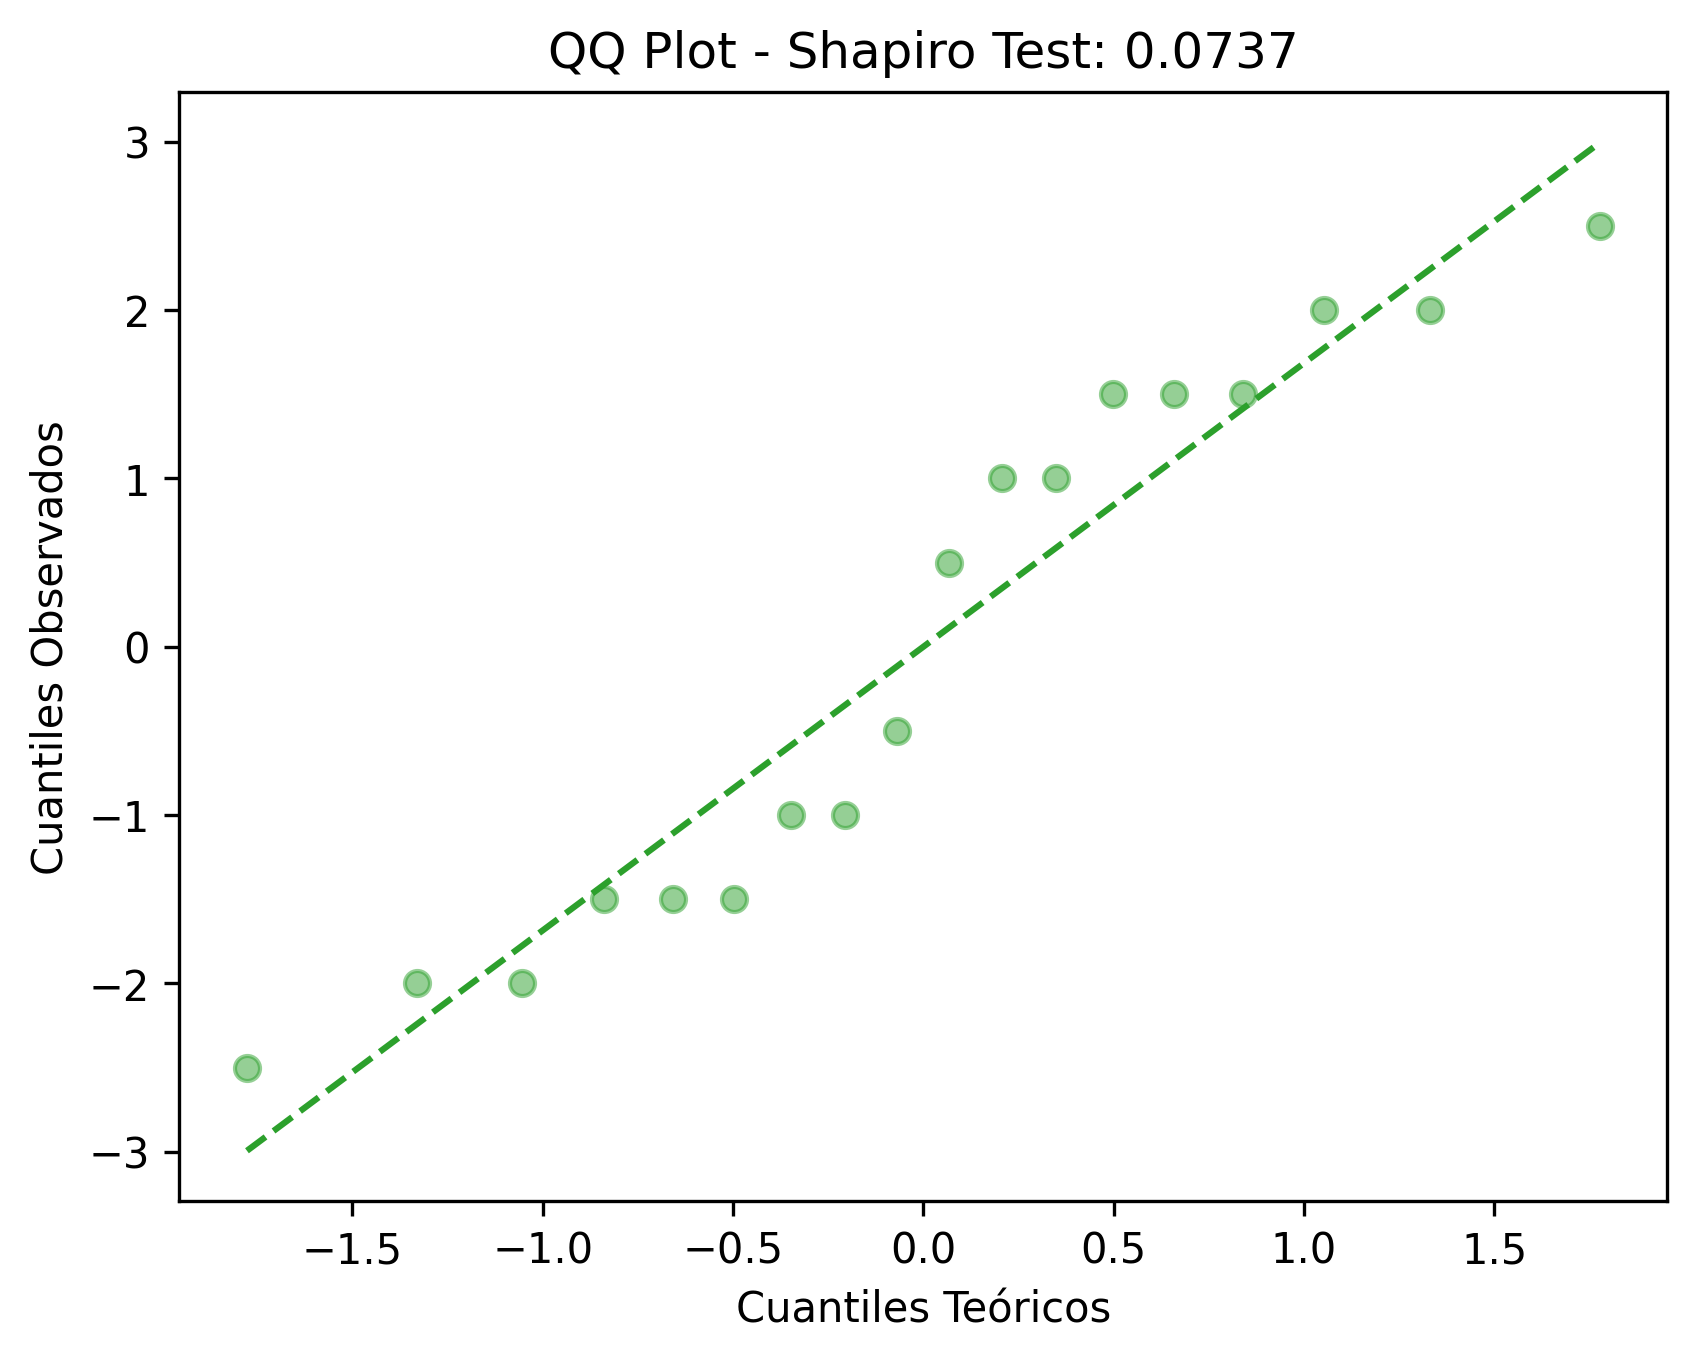

In [ ]:
### qqplot
fig, ax = plt.subplots(dpi = 300)
resid = model_co.resid
(osm, osr), (slope, intercept, r) = st.probplot(resid, fit = True)
ax.scatter(osm, osr, edgecolors = 'tab:green', facecolor = 'tab:green', alpha = 0.50)
ax.plot(osm, osm*slope + intercept, color = 'tab:green', linestyle = '--')
ax.set_xlabel('Cuantiles Teóricos')
ax.set_ylabel('Cuantiles Observados')
ax.set_title(f'QQ Plot - Shapiro Test: {st.shapiro(resid).pvalue:.4f}')
plt.show()


In [ ]:
shapiro_p = st.shapiro(resid).pvalue
print(f'Shapiro-Wilk Test: {shapiro_p:.4f}')

Shapiro-Wilk Test: 0.0737


Existe evidencia para poder afirmar que proviene de una distribución Normal.

Ahora, es necesario analizar la homocedasticidad de los datos.

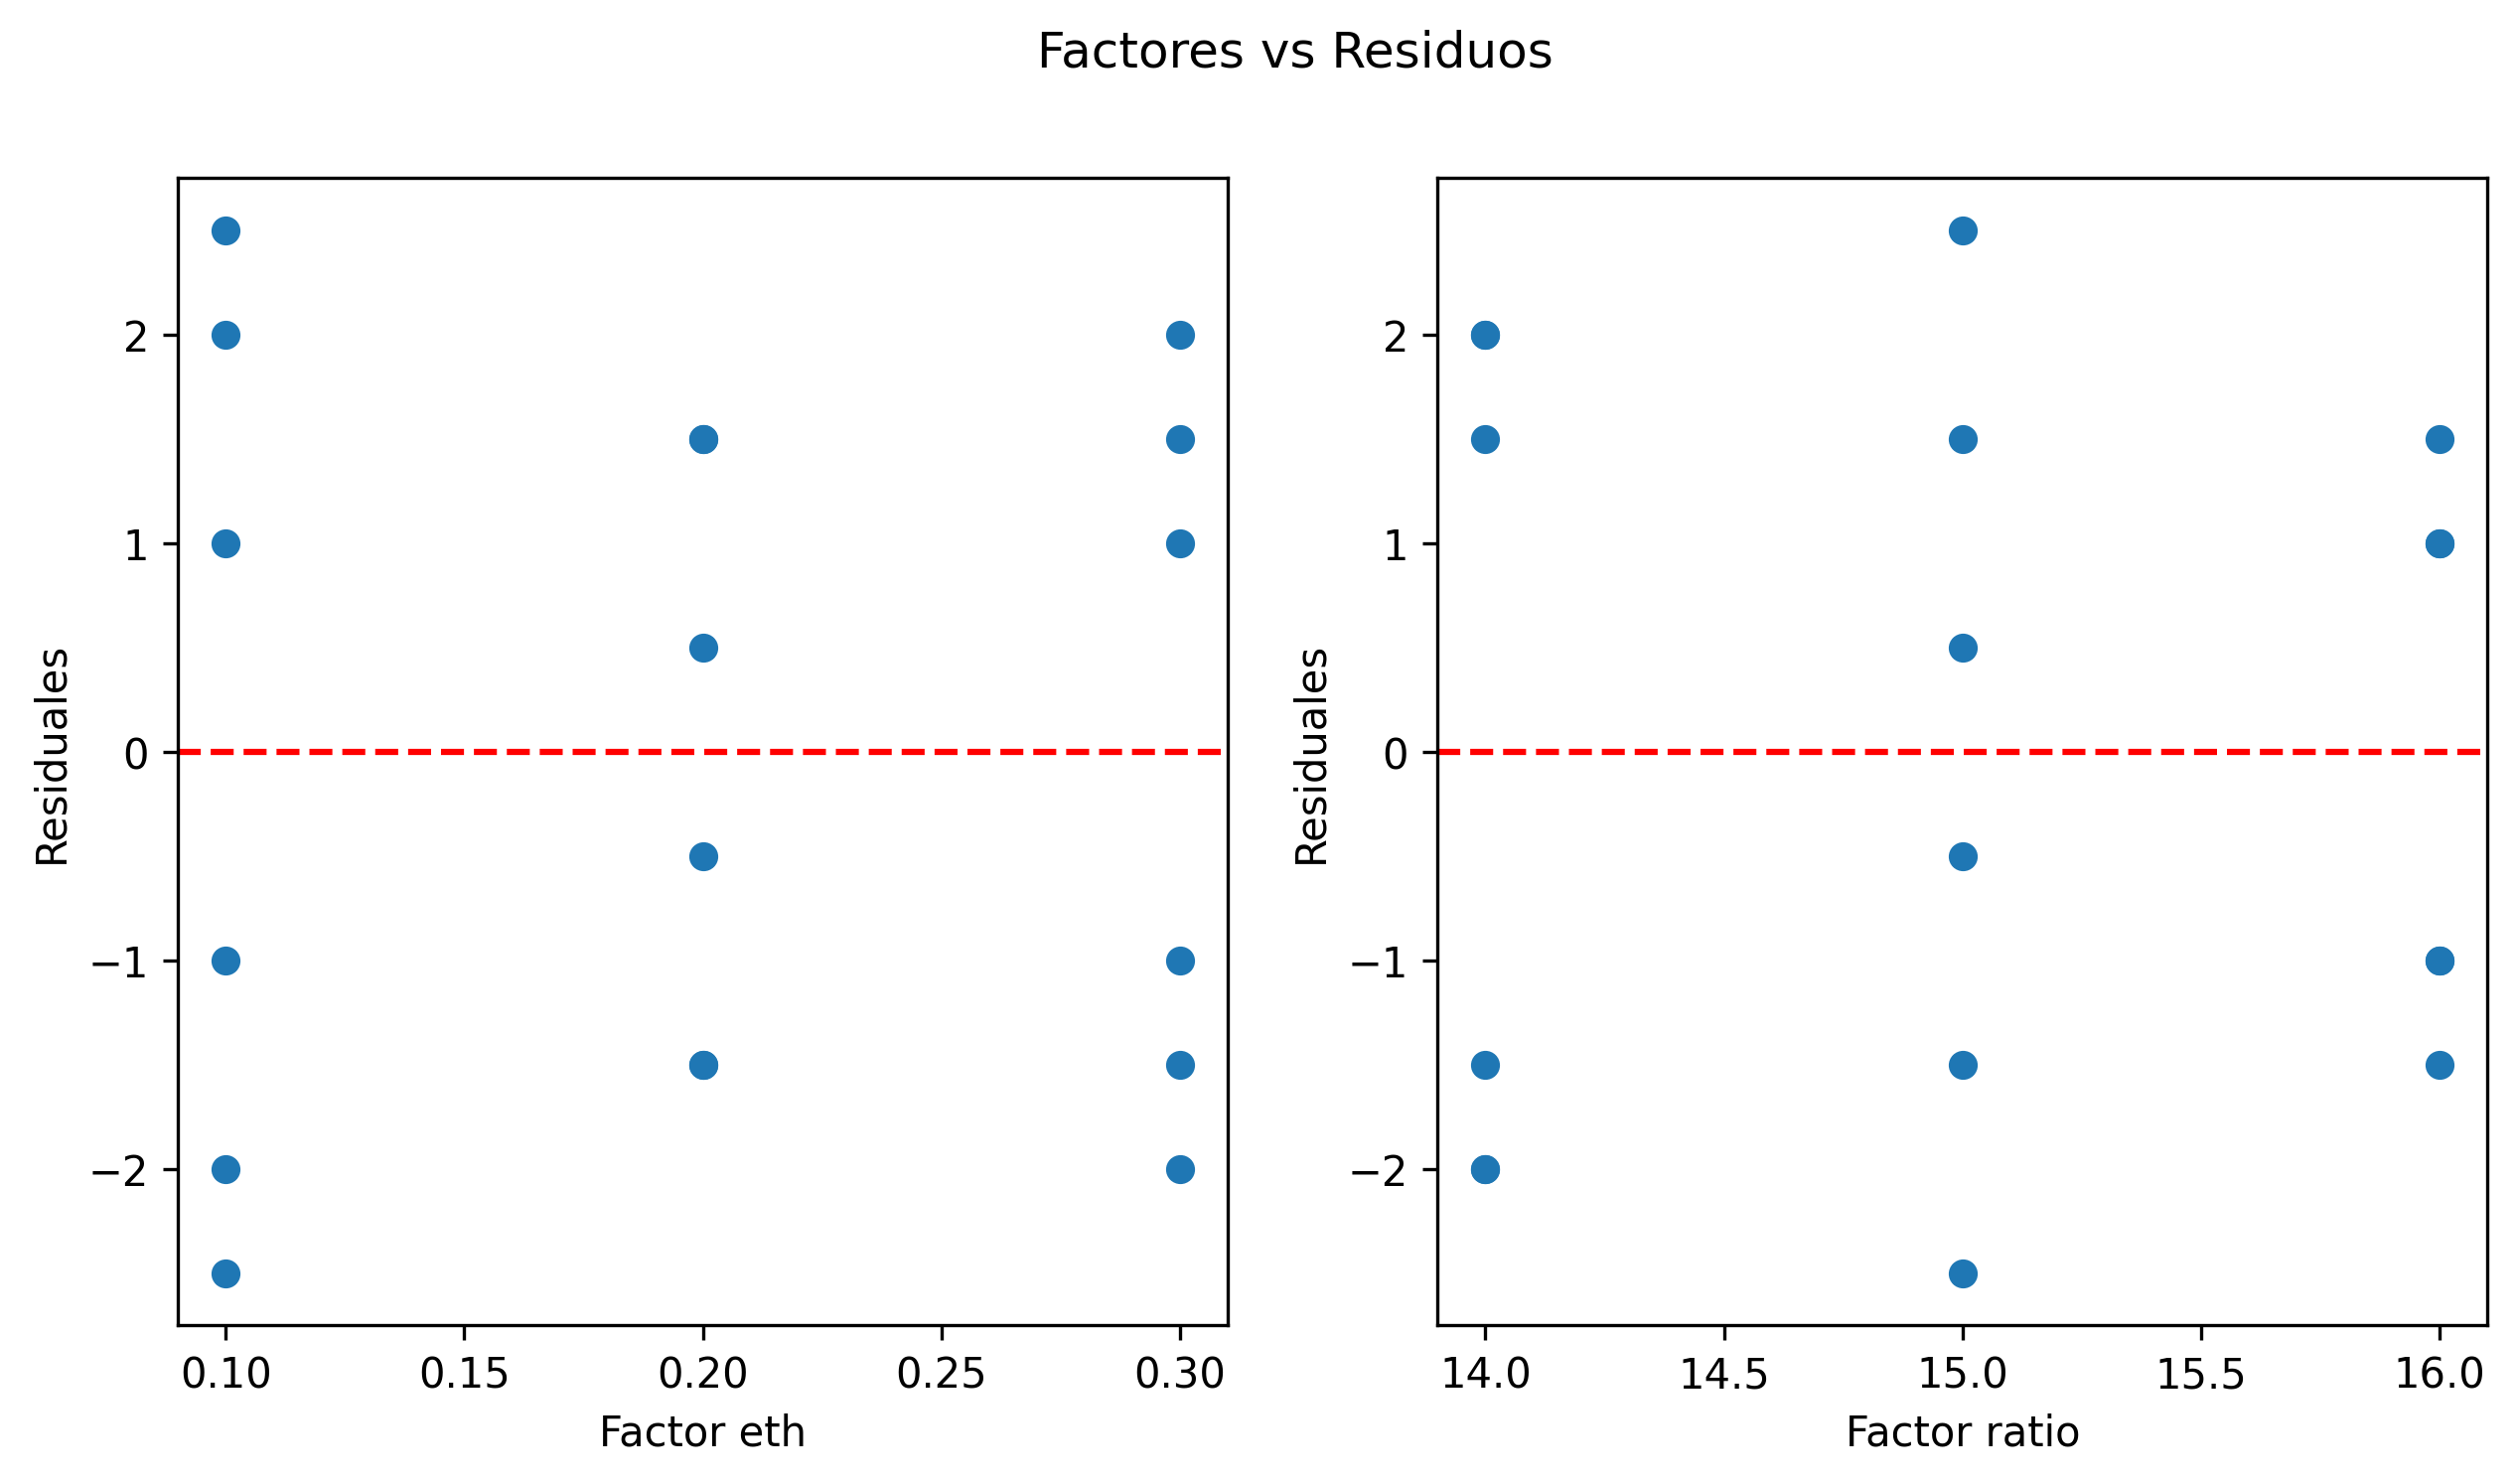

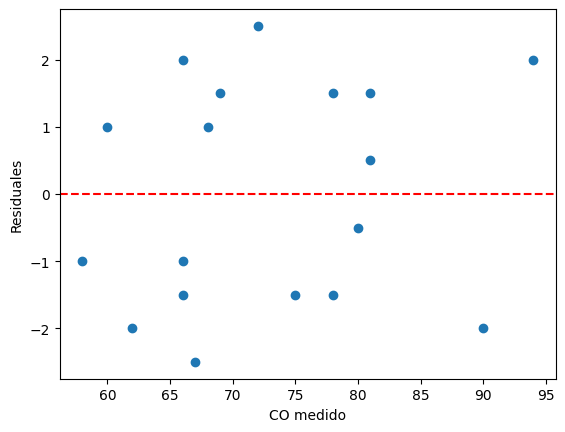

Breusch-Pagan Test: 0.0212


In [ ]:
# Plot de  factores
fig, ax = plt.subplots(1,2, figsize = (10,5), dpi = 300)

ax[0].scatter( df_co['eth'], model_co.resid,)
ax[0].axhline(y = 0, color = 'r', linestyle = '--')
ax[0].set_xlabel('Factor eth')
ax[0].set_ylabel('Residuales')

ax[1].scatter( df_co['ratio'], model_co.resid,)
ax[1].axhline(y = 0, color = 'r', linestyle = '--')
ax[1].set_xlabel('Factor ratio')
ax[1].set_ylabel('Residuales')
fig.suptitle('Factores vs Residuos')
plt.show()
# Plot de residuos
fig, ax = plt.subplots()
ax.scatter( df_co['co'], model_co.resid,)
ax.axhline(y = 0, color = 'r', linestyle = '--')
ax.set_xlabel('CO medido')
ax.set_ylabel('Residuales')
plt.show()


In [ ]:
### Test de Breusch-Pagan
bp_test = sms.het_breuschpagan(model_co.resid, model_co.model.exog)
print(f'Breusch-Pagan Test: {bp_test[1]:.4f}')

Breusch-Pagan Test: 0.0212


El test de Breusch-Pagan nos dice que existe heterocidasticidad en los datos. Por lo cual probamos con un transformación BoxCox

Lambda Óptimo: -1.0025

Two-Way ANOVA con BoxCox
                  df    sum_sq       mean_sq          F    PR(>F)
C(eth)           2.0  0.000010  4.811753e-06  23.716925  0.000258
C(ratio)         2.0  0.000023  1.139522e-05  56.166548  0.000008
C(eth):C(ratio)  4.0  0.000023  5.716250e-06  28.175153  0.000042
Residual         9.0  0.000002  2.028827e-07        NaN       NaN


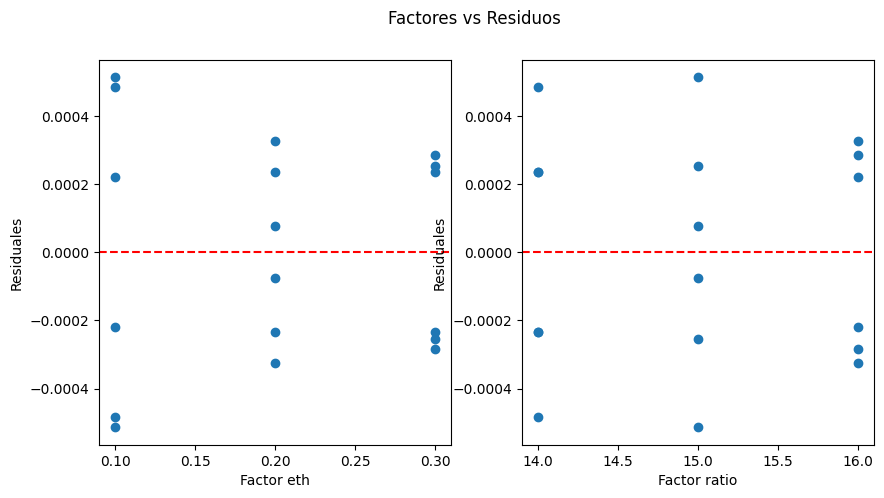

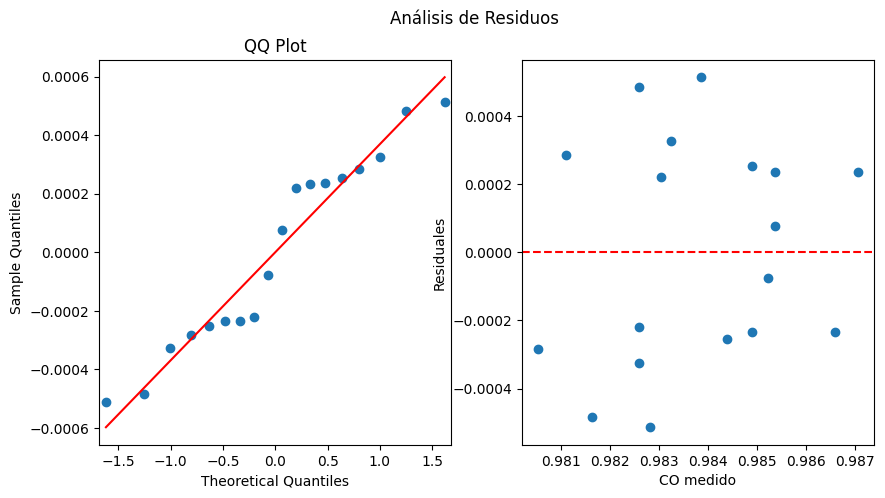

Shapiro-Wilk Test: 0.1453
Breusch-Pagan Test: 0.0212


In [ ]:
#
co_boxcox, lambda_box = st.boxcox(df_co['co'])
print(f'Lambda Óptimo: {lambda_box:.4f}')
df_co['co_boxcox'] = co_boxcox
#
model_co_boxcox = ols('co_boxcox ~ C(eth) * C(ratio)', data = df_co).fit()
anova_table_co_boxcox = sm.stats.anova_lm(model_co_boxcox)
print('\nTwo-Way ANOVA con BoxCox')
print(anova_table_co_boxcox)
#
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].scatter( df_co['eth'], model_co_boxcox.resid,)
ax[0].axhline(y = 0, color = 'r', linestyle = '--')
ax[0].set_xlabel('Factor eth')
ax[0].set_ylabel('Residuales')

ax[1].scatter( df_co['ratio'], model_co_boxcox.resid,)
ax[1].axhline(y = 0, color = 'r', linestyle = '--')
ax[1].set_xlabel('Factor ratio')
ax[1].set_ylabel('Residuales')
fig.suptitle('Factores vs Residuos')
plt.show()

# Plot residuos
fig, ax = plt.subplots(1,2, figsize = (10,5))
qqplot = sm.qqplot(model_co_boxcox.resid, line = 'q', ax = ax[0])
ax[0].set_title('QQ Plot')
ax[1].scatter( df_co['co_boxcox'], model_co_boxcox.resid,)
ax[1].axhline(y = 0, color = 'r', linestyle = '--')
ax[1].set_xlabel('CO medido')
ax[1].set_ylabel('Residuales')
fig.suptitle('Análisis de Residuos')
plt.show()

# Test Estadísticos
bp_test = sms.het_breuschpagan(model_co_boxcox.resid, model_co_boxcox.model.exog)
shapiro_test = st.shapiro(model_co_boxcox.resid)
print(f'Shapiro-Wilk Test: {shapiro_test.pvalue:.4f}')
print(f'Breusch-Pagan Test: {bp_test[1]:.4f}')

El test de Breusch-Pagan sigue indicando heterocidasticidad en los datos.

Para entender mejor los datos, es necesario analizar la interacción entre estos, para esto se puede generar el siguiente tipo de gráfico denominado *interaction plot*.

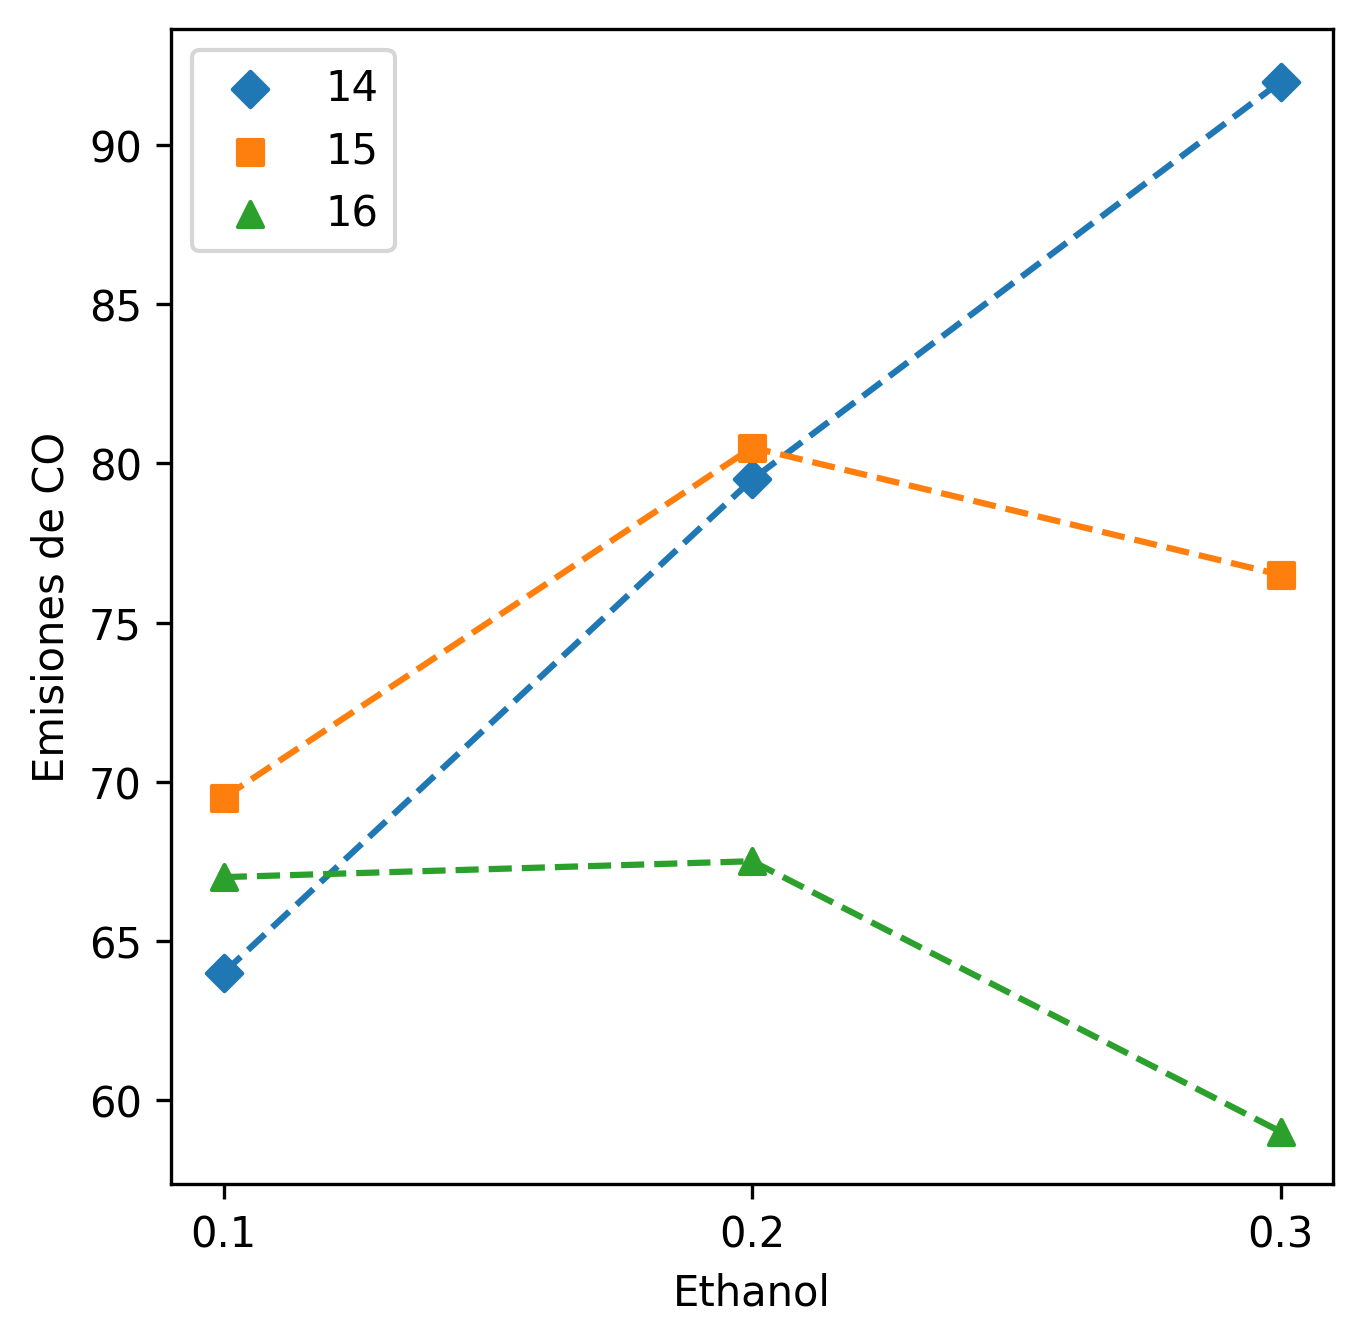

In [ ]:
### Primero devidimos por ratio
ratios = df_co['ratio'].unique()
icono = ['D', 's', '^']
fig, ax = plt.subplots(figsize = (5,5), dpi = 300)
for rat, icon in zip(ratios, icono):
    df_aux = df_co[df_co['ratio'] == rat]
    eth_aux = df_aux['eth'].unique()
    # calculamos la media de las emisiones de CO
    co_aux = []
    for eth in eth_aux:
        co_aux.append(df_aux[df_aux['eth'] == eth]['co'].mean())
    ax.scatter(eth_aux, co_aux, marker = icon, label = rat)
    ax.plot(eth_aux, co_aux, linestyle = '--')
ax.set_xticks([0.1, 0.2, 0.3])
ax.set_xlabel('Ethanol')
ax.set_ylabel('Emisiones de CO')
ax.legend()
plt.show()


Este tipo de gráficas nos permite entender como las variables que son parte del diseño del experimento.

Este tipo de gráficos puede ser automatizado mediante:https://www.statsmodels.org/dev/examples/notebooks/generated/categorical_interaction_plot.html

Es posible que durante la recolección de datos, puntos en las repeticiones se pierdan. En este caso, es posible seguir realizando un análisis ANOVA. En este caso, es pertinente definir estos datos perdidos como `NaN` (Not a Number), que define datos que no fueron recolectados.



In [ ]:
from patsy.contrasts import Sum
df_co.at[4, 'co'] = np.nan # ahora este dato es nan, significando su perdida
# sum contrast

### ANOVA

model_co_nan = ols('co ~ C(eth, Sum)*C(ratio, Sum)', data = df_co).fit()
anova_table_co_nan = sm.stats.anova_lm(model_co_nan, typ = 'II') # use typ not type
print('\nTwo-Way ANOVA con NaN, Type II')
display(anova_table_co_nan)

### ANOVA

model_co_nan = ols('co ~ C(eth, Sum)*C(ratio, Sum)', data = df_co).fit()
anova_table_co_nan = sm.stats.anova_lm(model_co_nan, typ = 'III') # use typ not type
print('\nTwo-Way ANOVA con NaN, Type III')
display(anova_table_co_nan)




Two-Way ANOVA con NaN, Type II


,sum_sq,df,F,PR(>F)
"C(eth, Sum)",302.815385,2.0,26.331773,0.000302
"C(ratio, Sum)",634.282051,2.0,55.154961,0.000021
"C(eth, Sum):C(ratio, Sum)",675.384615,4.0,29.364548,0.000078
Residual,46.000000,8.0,NaN,NaN



Two-Way ANOVA con NaN, Type III


,sum_sq,df,F,PR(>F)
Intercept,86067.200000,1.0,14968.208696,2.226913e-14
"C(eth, Sum)",314.272727,2.0,27.328063,2.657699e-04
"C(ratio, Sum)",644.818182,2.0,56.071146,1.965967e-05
"C(eth, Sum):C(ratio, Sum)",675.384615,4.0,29.364548,7.845021e-05
Residual,46.000000,8.0,NaN,NaN
